<a href="https://colab.research.google.com/github/mohdammar128/BTP_PROJECT/blob/main/light_weight_cnn_for_DDD_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Things to do for Image**

1. We need to extract Only those part of Image which is useful for us. (This will Increase the model to learn very accurate )
2.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
#-----------------------------------------
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler

# **Preprocessing and Analyzing Images**

In [4]:
image_path="/content/drive/MyDrive/btp_ddd/yaw_eye"


In [5]:
train_dir=os.path.join(image_path,"train")
test_dir=os.path.join(image_path,"test")
print(f"Train directory path: {train_dir}")
print(f"Test directory path: {test_dir}")

Train directory path: /content/drive/MyDrive/btp_ddd/yaw_eye/train
Test directory path: /content/drive/MyDrive/btp_ddd/yaw_eye/test


In [6]:
os.path.exists(train_dir)

True

In [7]:
os.path.isdir(train_dir)

True

In [8]:
labels=os.listdir(train_dir)

In [9]:
def check_image_sizes(image_dir,subfolder):
    image_dir=os.path.join(image_dir,subfolder)
    image_list=[]
    for filename in os.listdir(image_dir):
        # Construct the full file path
        file_path = os.path.join(image_dir, filename)

        # Check if the file is an image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            try:
                # Open the image and get its size
                with Image.open(file_path) as img:
                    width, height = img.size
                    image_list.append({
                        "label": f"{subfolder}/{filename.split('.')[0]}",
                        "width": width,
                        "height": height,
                        "aspect_ratio": width / height
                    })
            except Exception as e:
                print(f"Error opening {filename}: {e}")
    df=pd.DataFrame(image_list)
    return df


In [10]:
labels

['no_yawn', 'yawn', 'Closed', 'Open']

In [ ]:
df_close_train=check_image_sizes(train_dir,labels[0])
df_yawn_train=check_image_sizes(train_dir,labels[1])
df_open_train=check_image_sizes(train_dir,labels[3])
df_no_yawn_train=check_image_sizes(train_dir,labels[2])

In [ ]:
df_close_train.head()

,label,width,height,aspect_ratio
0,no_yawn/1061,640,480,1.333333
1,no_yawn/1214,640,480,1.333333
2,no_yawn/1202,640,480,1.333333
3,no_yawn/1062,640,480,1.333333
4,no_yawn/1281,640,480,1.333333


In [ ]:
df_yawn_train.head()

,label,width,height,aspect_ratio
0,yawn/136,640,480,1.333333
1,yawn/120,640,480,1.333333
2,yawn/128,640,480,1.333333
3,yawn/113,640,480,1.333333
4,yawn/129,640,480,1.333333


In [ ]:
df_open_train.head()

,label,width,height,aspect_ratio
0,Open/_117,400,300,1.333333
1,Open/_128,593,488,1.215164
2,Open/_109,404,300,1.346667
3,Open/_121,300,337,0.890208
4,Open/_108,422,300,1.406667


In [ ]:
df_no_yawn_train.head()

,label,width,height,aspect_ratio
0,Closed/_106,200,150,1.333333
1,Closed/_139,162,145,1.117241
2,Closed/_154,299,293,1.020478
3,Closed/_126,301,301,1.000000
4,Closed/_102,179,164,1.091463


In [ ]:
df_train=pd.concat([df_close_train,df_yawn_train,df_open_train,df_no_yawn_train])

In [ ]:
df_train.describe()

,width,height,aspect_ratio
count,2467.000000,2467.000000,2467.000000
mean,490.524524,397.139035,1.220692
std,218.786103,177.275132,0.173173
min,50.000000,40.000000,0.728337
25%,304.000000,300.000000,1.010396
50%,640.000000,480.000000,1.333333
75%,640.000000,480.000000,1.333333
max,1625.000000,1625.000000,2.096000


In [12]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Crop to a 224x224 square (common size for CNNs like ResNet)
    transforms.ToTensor() ,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset=datasets.ImageFolder(root=train_dir,transform=transform)
test_dataset=datasets.ImageFolder(root=test_dir,transform=transform)

In [ ]:
print(f"Train data set classes {train_dataset.classes}")



Train data set classes ['Closed', 'Open', 'no_yawn', 'yawn']


# **Visualizing Image**

In [14]:
batch_size=16
num_train_datasets=len(train_dataset)
print(f"Number of training images: {num_train_datasets}")
indices=list(range(num_train_datasets))
np.random.shuffle(indices) # shuffel the indices randomly
split=int(np.floor(0.2*num_train_datasets))
train_idx,val_idx=indices[split:],indices[:split] #train,validation
print(f"Number of training images: {len(train_idx)}")
print(f"Number of validation images: {len(val_idx)}")

Number of training images: 2467
Number of training images: 1974
Number of validation images: 493


In [ ]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    tensor = tensor * std + mean  # Revert normalization
    return tensor

def show_images(images, labels, class_names):
    images = images.numpy()  # Convert to numpy array
    fig, axes = plt.subplots(1, len(images), figsize=(24, 12))  # Create a grid to display the images
    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))  # Convert from CxHxW to HxWxC for displaying
        axes[i].imshow(image)
        axes[i].set_title(class_names[labels[i]])  # Set the class label as the title
        axes[i].axis('off')
    plt.show()


In [23]:
train_sampler=SubsetRandomSampler(train_idx)
val_sampler=SubsetRandomSampler(val_idx)

train_loader=DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
val_loader=DataLoader(train_dataset,batch_size=batch_size,sampler=val_sampler)
test_loader=DataLoader(test_dataset,batch_size=batch_size)

In [ ]:
print(f"Number of batches in train loader: {len(train_loader)} and Number of Images {len(train_loader)*16}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 124 and Number of Images 1984
Number of batches in validation loader: 31
Number of batches in test loader: 28


In [ ]:
dataiter=iter(train_loader)
images,labels=next(dataiter)
print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.numpy()}")

Shape of images: torch.Size([16, 3, 224, 224])
Shape of labels: [0 3 2 0 0 1 0 0 3 2 3 1 0 2 2 0]


In [ ]:
mean=[0.485,0.456,0.406]
srd=[0.229,0.224,0.225]
images_tensor=denormalize(images,mean,srd)

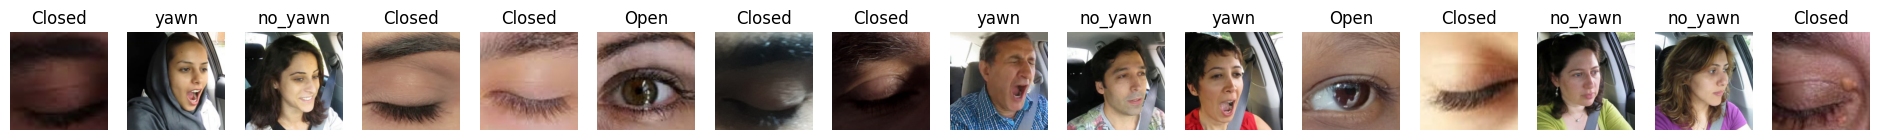

In [ ]:
show_images(images_tensor,labels,train_dataset.classes)

# **Creating neural network Architecture**

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

In [16]:

path_to_checkpoint="/content/drive/MyDrive/btp_ddd/checkpoint.pth"


In [18]:
torch.manual_seed(42)

In [17]:
class LightWeightCNN(nn.Module):
  def __init__(self):
    super(LightWeightCNN,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) #224*224*3 to 112*112*32
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1) # to 56*56*64
    self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1) #to 28*28*128
    self.conv4 = nn.Conv2d(in_channels= 128, out_channels=128, kernel_size=3, padding=1,stride=1) # 14*14*128
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1,stride=1) # 7*7*128
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1=nn.Linear(in_features=128*7*7,out_features=1024)
    self.fc2=nn.Linear(in_features=1024,out_features=4)
    self.dropout = nn.Dropout2d(0.2)  # Add dropout layer with a dropout rate of 0.2 for convoluted network
    self.dropout1 = nn.Dropout(0.2)  # Add dropout layer with a dropout rate of 0.2 for neural network

  def forward(self,x):
    x=self.dropout(self.pool(F.relu(self.conv1(x))))
    x=self.dropout(self.pool(F.relu(self.conv2(x))))
    x=self.dropout(self.pool(F.relu(self.conv3(x))))
    x=self.pool(F.relu(self.conv4(x)))
    x=self.pool(F.relu(self.conv5(x)))
    x=x.view(-1,128*7*7)
    x=self.dropout1(x)
    x=F.relu(self.fc1(x))
    x=self.dropout1(x)
    x=self.fc2(x)
    return x




In [19]:
model=LightWeightCNN()
print(model)

LightWeightCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (dropout1): Dropout(p=0.2, inplace=False)
)


In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer=optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [21]:
checkpoint = torch.load(path_to_checkpoint)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start = checkpoint['epoch']
loss = checkpoint['loss']


<ipython-input-21-aa537e2d2383>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_checkpoint)


In [24]:
n_epochs = 70
valid_loss_min = np.Inf  # Track change in validation loss

for epoch in range(start, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    correct_train = 0
    correct_valid = 0
    total_train = 0
    total_valid = 0

    # Training of model
    model.train()  # Set model to training mode
    for data, target in train_loader:
        optimizer.zero_grad()  # Clear gradients
        output = model(data)   # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        train_loss += loss.item() * data.size(0)  # Sum up batch loss

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)  # Get the predicted class (output is logits)
        correct_train += (predicted == target).sum().item()  # Count correct predictions
        total_train += target.size(0)  # Total number of samples

    # Model validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        for data, target in val_loader:
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Calculate validation loss
            valid_loss += loss.item() * data.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)  # Get the predicted class
            correct_valid += (predicted == target).sum().item()  # Count correct predictions
            total_valid += target.size(0)  # Total number of samples

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(val_loader.sampler)

    # Calculate accuracy
    train_accuracy = 100. * correct_train / total_train
    valid_accuracy = 100. * correct_valid / total_valid

    print(f"Epoch: {epoch}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {valid_loss:.6f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%\tValidation Accuracy: {valid_accuracy:.2f}%")

    # Create checkpoint for the current model state
    checkpoint = {
        'epoch': epoch,               # Save current epoch number
        'model_state_dict': model.state_dict(),  # Save model parameters
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state
        'loss': loss                  # Optionally, save the current loss
    }

    # Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(checkpoint, path_to_checkpoint)  # Save the checkpoint
        valid_loss_min = valid_loss  # Update the new minimum validation loss


Epoch: 40	Training Loss: 0.064714	Validation Loss: 0.023940
Training Accuracy: 98.28%	Validation Accuracy: 98.99%
Validation loss decreased (inf --> 0.023940). Saving model ...
Epoch: 41	Training Loss: 0.035037	Validation Loss: 0.017577
Training Accuracy: 98.89%	Validation Accuracy: 99.39%
Validation loss decreased (0.023940 --> 0.017577). Saving model ...
Epoch: 42	Training Loss: 0.055117	Validation Loss: 0.038450
Training Accuracy: 98.18%	Validation Accuracy: 98.58%
Epoch: 43	Training Loss: 0.035060	Validation Loss: 0.021056
Training Accuracy: 99.14%	Validation Accuracy: 99.19%
Epoch: 44	Training Loss: 0.024915	Validation Loss: 0.040365
Training Accuracy: 99.14%	Validation Accuracy: 98.58%
Epoch: 45	Training Loss: 0.027451	Validation Loss: 0.032630
Training Accuracy: 99.19%	Validation Accuracy: 98.78%
Epoch: 46	Training Loss: 0.030755	Validation Loss: 0.023168
Training Accuracy: 98.83%	Validation Accuracy: 99.39%
Epoch: 47	Training Loss: 0.044651	Validation Loss: 0.081783
Training Ac

### **Testing Model***

In [25]:
 # Replace 'model.pth' with your model file path
model.eval()
correct=0;
total=0;


In [26]:
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        total += labels.size(0)  # Increment total
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

Accuracy of the model on the test dataset: 96.77%


In [ ]:
image_path = "https://media.istockphoto.com/id/649730480/photo/wakey-wakey.jpg?s=612x612&w=0&k=20&c=Yj6N8WK_c7AsNKEMSR2ugaLHF5ALgshX3Wq7yh0MhJM="
preprocessed_image = preprocess_image(image_path)
prediction = model.predict(preprocessed_image)
predicted_class = np.argmax(prediction, axis=1)  # Get class with the highest probability
print("Predicted class:", predicted_class)
